# IMMC 2020: With Variable Heuristic and Proper Product List
### Importing Modules and Data

In [1]:
import pandas as pd
import copy
import re
import random
import math, statistics
import numpy as np
import gc
import matplotlib.pyplot as plt
from pprint import pprint

median_income = 9733/365
loss_aversion_coefficient = 2
max_shelf_capacity = 150
max_shopper_capacity = 300
units_per_object = 1
max_pdt_per_shelf = 3
pdts_per_shopper = 3
crowd_avoidance = 0.5
mean_shopper_size=50 #mean size of shopper

pdt_csv_data = pd.read_csv("StoreData_IMMC_CSV.csv")
print(pdt_csv_data.head())

          department product_category       product_type     brand  \
0    TV&Home Theater   TVS 30" to 45"    1080p LED Smart  Brand BB   
1  Computers&Tablets          Laptops  2-in-1 Chromebook   Brand A   
2  Computers&Tablets          Laptops  2-in-1 Chromebook  Brand BB   
3  Computers&Tablets          Laptops  2-in-1 Chromebook   Brand G   
4  Computers&Tablets          Laptops  2-in-1 Chromebook   Brand P   

                                                name  initial_price  \
0                 40" 1080p Smart LED HDTV, 5 Series         259.99   
1  2-in-1 11.6" Touch-Screen Chromebook, Intel Ce...         279.99   
2  2-in-1 12.2" Touch-Screen Chromebook, Intel Ce...         449.00   
3  2-in-1 14" Touch-Screen Chromebook, Intel Core...         549.00   
4  2-in-1 14" Touch-Screen Chromebook, Intel Core...         599.00   

   discounted_price  qty  customer_rating  brand_rating  percentage_usage  \
0            179.99    8              4.7      4.623810              0.95  

In [2]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

## Determining the Popularity of Product
### Impact of Discount on Popularity

In [3]:
# Traditional Econs Approach
def q1_over_q0(p0, p1, percentage_usage):
    x = (p0 - p1)*(percentage_usage/median_income) 
    return (math.exp(x))

# Behavioural Econs Approach
def prospect_utility(x):
    if x > 0:
        return(math.log(x+1))
    else:
        return(-loss_aversion_coefficient * math.log(-x + 1))

def increase_utility(p0, p1):
    return(prospect_utility(p0 - p1))

# Helper Variables
max_increase_utility = increase_utility(3329.99, 2199.99)
min_increase_utility = 0
max_q1_over_q0 = q1_over_q0(3329.99, 2199.99, 1)
min_q1_over_qo = 1

# Combined Effect [Between 0 and 1]
def popularity_due_to_discount(p0, p1, percentage_usage):
    traditional_econs_adjusted = (q1_over_q0(p0, p1, percentage_usage)-min_q1_over_qo)/max_q1_over_q0
    behavioural_econs_adjusted = (increase_utility(p0, p1)-min_increase_utility)/max_increase_utility

    total_adjusted = statistics.mean([traditional_econs_adjusted, behavioural_econs_adjusted])
    return(total_adjusted)

### Effect of Loss Adversion on Popularity

In [4]:
# [Between 0 and 1]
def popularity_due_to_loss_aversion(qty):
    return(math.exp(-qty/loss_aversion_coefficient))

### Effects of Saliency Bias on Popularity (TO DO)

In [5]:
def popularity_due_to_saliency_bias(size, qty):
    return sigmoid(size*qty)

### Effects of Ratings on Popularity

In [6]:
# [Between 0 and 1]
def popularity_due_to_rating(pdt_rating, brand_rating):
    raw_brand = (0.8*pdt_rating + 0.2*brand_rating)
    return(raw_brand/5)

## Creating Product Class and List

In [7]:
class product:
    # Popularity Coefficients
    pop_loss_adversion_coefficient = 0.44
    pop_saliency_coefficient = 0.6
    pop_rating_coefficient = 0.5
    
    
    # Raw Data
    def __init__(self, index, name, department, product_category, product_type, brand, initial_price, discounted_price, qty, customer_rating, brand_rating=5, percentage_usage=0.5, size=20):
        self.name = name
        self.index = index
        self.department = department
        self.product_category = product_category
        self.product_type = product_type
        self.brand = brand
        self.initial_price = initial_price
        self.discounted_price = discounted_price
        self.qty = qty
        self.customer_rating = customer_rating
        self.brand_rating = brand_rating
        self.percentage_usage = percentage_usage
        self.size = size
        
        self.popularity = 0
    
    # Processed Data
    
    def set_popularity(self):
        discount_factor = popularity_due_to_discount(self.initial_price, self.discounted_price, self.percentage_usage)
        loss_adversion_factor = popularity_due_to_loss_aversion(self.qty)
        saliency_factor = popularity_due_to_saliency_bias(self.size, self.qty)
        rating_factor = popularity_due_to_rating(self.customer_rating, self.brand_rating)
        
        initial_popularity = self.pop_loss_adversion_coefficient*loss_adversion_factor + self.pop_saliency_coefficient*saliency_factor + self.pop_rating_coefficient*rating_factor
        self.popularity = sigmoid(initial_popularity + discount_factor)
        
        
        

In [8]:
# Populating the Product List
pdt_list = []
pdt_counter = 0
for index, row in pdt_csv_data.iterrows():
    
    total_qty = row["qty"]
    unit_size = row["index_size"]
    while True:
        
        cur_qty = min(min(int(max_shelf_capacity/unit_size), total_qty), units_per_object)
        print("index", index, "department", row["department"], "qty", cur_qty, "net_size", cur_qty*unit_size)
        total_qty -= cur_qty
        
        cur_pdt = product(index, row["name"], row["department"], row["product_category"], row["product_type"], row["brand"], row["initial_price"], row["discounted_price"], cur_qty, row["customer_rating"], size=unit_size, brand_rating=row["brand_rating"], percentage_usage=row["percentage_usage"])
        cur_pdt.set_popularity()
        
        pdt_counter += 1
        pdt_list.append(cur_pdt)
        
        if total_qty <=0:
            break

print("pdt_list len", len(pdt_list))
print("Number of products", pdt_counter)

index 0 department TV&Home Theater qty 1 net_size 2.012689585
index 0 department TV&Home Theater qty 1 net_size 2.012689585
index 0 department TV&Home Theater qty 1 net_size 2.012689585
index 0 department TV&Home Theater qty 1 net_size 2.012689585
index 0 department TV&Home Theater qty 1 net_size 2.012689585
index 0 department TV&Home Theater qty 1 net_size 2.012689585
index 0 department TV&Home Theater qty 1 net_size 2.012689585
index 0 department TV&Home Theater qty 1 net_size 2.012689585
index 1 department Computers&Tablets qty 1 net_size 0.1084217678
index 1 department Computers&Tablets qty 1 net_size 0.1084217678
index 1 department Computers&Tablets qty 1 net_size 0.1084217678
index 1 department Computers&Tablets qty 1 net_size 0.1084217678
index 1 department Computers&Tablets qty 1 net_size 0.1084217678
index 1 department Computers&Tablets qty 1 net_size 0.1084217678
index 1 department Computers&Tablets qty 1 net_size 0.1084217678
index 1 department Computers&Tablets qty 1 net_si

index 21 department TV&Home Theater qty 1 net_size 4.957578881
index 21 department TV&Home Theater qty 1 net_size 4.957578881
index 21 department TV&Home Theater qty 1 net_size 4.957578881
index 21 department TV&Home Theater qty 1 net_size 4.957578881
index 21 department TV&Home Theater qty 1 net_size 4.957578881
index 21 department TV&Home Theater qty 1 net_size 4.957578881
index 21 department TV&Home Theater qty 1 net_size 4.957578881
index 21 department TV&Home Theater qty 1 net_size 4.957578881
index 22 department TV&Home Theater qty 1 net_size 4.957578881
index 22 department TV&Home Theater qty 1 net_size 4.957578881
index 22 department TV&Home Theater qty 1 net_size 4.957578881
index 22 department TV&Home Theater qty 1 net_size 4.957578881
index 22 department TV&Home Theater qty 1 net_size 4.957578881
index 22 department TV&Home Theater qty 1 net_size 4.957578881
index 22 department TV&Home Theater qty 1 net_size 4.957578881
index 22 department TV&Home Theater qty 1 net_size 4.95

index 34 department TV&Home Theater qty 1 net_size 6.624022282
index 34 department TV&Home Theater qty 1 net_size 6.624022282
index 34 department TV&Home Theater qty 1 net_size 6.624022282
index 34 department TV&Home Theater qty 1 net_size 6.624022282
index 34 department TV&Home Theater qty 1 net_size 6.624022282
index 34 department TV&Home Theater qty 1 net_size 6.624022282
index 34 department TV&Home Theater qty 1 net_size 6.624022282
index 35 department TV&Home Theater qty 1 net_size 6.624022282
index 35 department TV&Home Theater qty 1 net_size 6.624022282
index 35 department TV&Home Theater qty 1 net_size 6.624022282
index 35 department TV&Home Theater qty 1 net_size 6.624022282
index 35 department TV&Home Theater qty 1 net_size 6.624022282
index 35 department TV&Home Theater qty 1 net_size 6.624022282
index 35 department TV&Home Theater qty 1 net_size 6.624022282
index 35 department TV&Home Theater qty 1 net_size 6.624022282
index 35 department TV&Home Theater qty 1 net_size 6.62

index 44 department Computers&Tablets qty 1 net_size 1.088366056
index 44 department Computers&Tablets qty 1 net_size 1.088366056
index 44 department Computers&Tablets qty 1 net_size 1.088366056
index 45 department Computers&Tablets qty 1 net_size 1.088366056
index 45 department Computers&Tablets qty 1 net_size 1.088366056
index 45 department Computers&Tablets qty 1 net_size 1.088366056
index 45 department Computers&Tablets qty 1 net_size 1.088366056
index 45 department Computers&Tablets qty 1 net_size 1.088366056
index 45 department Computers&Tablets qty 1 net_size 1.088366056
index 45 department Computers&Tablets qty 1 net_size 1.088366056
index 45 department Computers&Tablets qty 1 net_size 1.088366056
index 45 department Computers&Tablets qty 1 net_size 1.088366056
index 45 department Computers&Tablets qty 1 net_size 1.088366056
index 45 department Computers&Tablets qty 1 net_size 1.088366056
index 45 department Computers&Tablets qty 1 net_size 1.088366056
index 46 department Compu

index 57 department Cameras qty 1 net_size 0.05161575841
index 57 department Cameras qty 1 net_size 0.05161575841
index 57 department Cameras qty 1 net_size 0.05161575841
index 57 department Cameras qty 1 net_size 0.05161575841
index 57 department Cameras qty 1 net_size 0.05161575841
index 57 department Cameras qty 1 net_size 0.05161575841
index 57 department Cameras qty 1 net_size 0.05161575841
index 57 department Cameras qty 1 net_size 0.05161575841
index 57 department Cameras qty 1 net_size 0.05161575841
index 57 department Cameras qty 1 net_size 0.05161575841
index 57 department Cameras qty 1 net_size 0.05161575841
index 57 department Cameras qty 1 net_size 0.05161575841
index 57 department Cameras qty 1 net_size 0.05161575841
index 58 department Cameras qty 1 net_size 0.05161575841
index 58 department Cameras qty 1 net_size 0.05161575841
index 58 department Cameras qty 1 net_size 0.05161575841
index 58 department Cameras qty 1 net_size 0.05161575841
index 58 department Cameras qty

index 73 department Appliances qty 1 net_size 22.32523142
index 74 department Appliances qty 1 net_size 34.67933792
index 74 department Appliances qty 1 net_size 34.67933792
index 74 department Appliances qty 1 net_size 34.67933792
index 74 department Appliances qty 1 net_size 34.67933792
index 74 department Appliances qty 1 net_size 34.67933792
index 75 department Appliances qty 1 net_size 34.67933792
index 75 department Appliances qty 1 net_size 34.67933792
index 75 department Appliances qty 1 net_size 34.67933792
index 75 department Appliances qty 1 net_size 34.67933792
index 75 department Appliances qty 1 net_size 34.67933792
index 76 department Appliances qty 1 net_size 34.67933792
index 76 department Appliances qty 1 net_size 34.67933792
index 76 department Appliances qty 1 net_size 34.67933792
index 76 department Appliances qty 1 net_size 34.67933792
index 76 department Appliances qty 1 net_size 34.67933792
index 76 department Appliances qty 1 net_size 34.67933792
index 76 depar

index 93 department Computers&Tablets qty 1 net_size 4.642302183
index 93 department Computers&Tablets qty 1 net_size 4.642302183
index 93 department Computers&Tablets qty 1 net_size 4.642302183
index 93 department Computers&Tablets qty 1 net_size 4.642302183
index 93 department Computers&Tablets qty 1 net_size 4.642302183
index 93 department Computers&Tablets qty 1 net_size 4.642302183
index 93 department Computers&Tablets qty 1 net_size 4.642302183
index 93 department Computers&Tablets qty 1 net_size 4.642302183
index 94 department Computers&Tablets qty 1 net_size 4.642302183
index 94 department Computers&Tablets qty 1 net_size 4.642302183
index 94 department Computers&Tablets qty 1 net_size 4.642302183
index 94 department Computers&Tablets qty 1 net_size 4.642302183
index 94 department Computers&Tablets qty 1 net_size 4.642302183
index 94 department Computers&Tablets qty 1 net_size 4.642302183
index 94 department Computers&Tablets qty 1 net_size 4.642302183
index 94 department Compu

index 117 department Appliances qty 1 net_size 100.0
index 117 department Appliances qty 1 net_size 100.0
index 117 department Appliances qty 1 net_size 100.0
index 117 department Appliances qty 1 net_size 100.0
index 118 department Appliances qty 1 net_size 0.8602626379
index 118 department Appliances qty 1 net_size 0.8602626379
index 118 department Appliances qty 1 net_size 0.8602626379
index 118 department Appliances qty 1 net_size 0.8602626379
index 118 department Appliances qty 1 net_size 0.8602626379
index 118 department Appliances qty 1 net_size 0.8602626379
index 118 department Appliances qty 1 net_size 0.8602626379
index 118 department Appliances qty 1 net_size 0.8602626379
index 118 department Appliances qty 1 net_size 0.8602626379
index 118 department Appliances qty 1 net_size 0.8602626379
index 118 department Appliances qty 1 net_size 0.8602626379
index 118 department Appliances qty 1 net_size 0.8602626379
index 118 department Appliances qty 1 net_size 0.8602626379
index 11

index 132 department Audio qty 1 net_size 0.008220287406
index 132 department Audio qty 1 net_size 0.008220287406
index 132 department Audio qty 1 net_size 0.008220287406
index 132 department Audio qty 1 net_size 0.008220287406
index 132 department Audio qty 1 net_size 0.008220287406
index 132 department Audio qty 1 net_size 0.008220287406
index 132 department Audio qty 1 net_size 0.008220287406
index 132 department Audio qty 1 net_size 0.008220287406
index 132 department Audio qty 1 net_size 0.008220287406
index 132 department Audio qty 1 net_size 0.008220287406
index 132 department Audio qty 1 net_size 0.008220287406
index 132 department Audio qty 1 net_size 0.008220287406
index 132 department Audio qty 1 net_size 0.008220287406
index 132 department Audio qty 1 net_size 0.008220287406
index 132 department Audio qty 1 net_size 0.008220287406
index 132 department Audio qty 1 net_size 0.008220287406
index 132 department Audio qty 1 net_size 0.008220287406
index 133 department Audio qty 

In [34]:
department_popularities = {
    "Appliances": 0,
    "Audio": 0,
    "Cameras": 0,
    "Cell Phones": 0,
    "Computers&Tablets": 0,
    "TV&Home Theater": 0,
    "Video Gaming": 0
}
department_qty = {
    "Appliances": 0,
    "Audio": 0,
    "Cameras": 0,
    "Cell Phones": 0,
    "Computers&Tablets": 0,
    "TV&Home Theater": 0,
    "Video Gaming": 0
}


total_objects = 0
for department, total_pop in department_popularities.items():
    number_of_objects = 0
    for pdt in pdt_list:
        if pdt.department == department:
            number_of_objects += 1
    total_objects += number_of_objects
    print("Department:", department, "Number of Objects", number_of_objects)
    
print("Total Number of Objects", len(pdt_list))

print("--------")

total_pop = 0
for pdt in pdt_list:
    department_popularities[pdt.department]+= pdt.popularity*pdt.qty
    department_qty[pdt.department]+= pdt.qty
    total_pop += pdt.popularity*pdt.qty

for department, pop in department_popularities.items():
    print("Department:", department, "Average Popularity", pop/department_qty[department])
print("Global Average Popularity:", total_pop/len(pdt_list))

Department: Appliances Number of Objects 257
Department: Audio Number of Objects 50
Department: Cameras Number of Objects 165
Department: Cell Phones Number of Objects 55
Department: Computers&Tablets Number of Objects 444
Department: TV&Home Theater Number of Objects 383
Department: Video Gaming Number of Objects 181
Total Number of Objects 1535
--------
Department: Appliances Average Popularity 0.8389350550900967
Department: Audio Average Popularity 0.7909613754768059
Department: Cameras Average Popularity 0.8028821374113138
Department: Cell Phones Average Popularity 0.7798840389861017
Department: Computers&Tablets Average Popularity 0.814878007267299
Department: TV&Home Theater Average Popularity 0.8321277481983057
Department: Video Gaming Average Popularity 0.8275033824709389
Global Average Popularity 0.8213761744384138


In [10]:
pdt_list[4].index

0

## Creating Shelf Class and Layout Object

In [11]:
class shelf:
    # Class Variables
    
    def __init__(self, department):
        self.pdts = []
        self.pdt_set = set()
        self.department = department
        self.cur_capacity = 0
    
    def add_pdt(self, pdt):
        # Check Department
        # print("Adding Product")
        # print("  product_department", pdt.department)
        # print("  shelf_department", self.department)
        if pdt.department != self.department:
            return -1
        
        # If shelf can accomodate the product
        if self.cur_capacity + pdt.size*pdt.qty <= max_shelf_capacity:
            self.cur_capacity += pdt.size*pdt.qty
            self.pdts.append(pdt)
            self.pdt_set.add(pdt.index)
            return 0
        
        # If shelf is full
        return -1

In [12]:
class layout:
    
    def __init__(self, grid, counter, entrance, exit, shelf_list=[], pdt_list=[]):
        self.counter = counter
        self.value_of_goods_bought = 0
        self.shopper_size = 0
        self.entrance = entrance
        self.exit = exit
        
        # Grid is a 2d matrix where shelves are 1 indexed
        self.grid = copy.deepcopy(grid)
        self.shelf_list = copy.deepcopy(shelf_list)
        
        # A* Grid is a grid where shelves are labelled as 1
        self.a_star_grid = copy.deepcopy(grid)
        for i in range(len(self.a_star_grid)):
            for j in range(len(self.a_star_grid)):
                if self.a_star_grid[i][j] > 1:
                    self.a_star_grid[i][j] = 1
                    
        # Shopper Density Grid is a grid to record the density of shoppers; shelves have a density of 99
        self.shopper_density_grid = copy.deepcopy(self.a_star_grid)
        for i in range(len(self.shopper_density_grid)):
            for j in range(len(self.shopper_density_grid)):
                if self.shopper_density_grid[i][j] == 1:
                    self.shopper_density_grid[i][j] = -1
                    
        # Price Density Grid is a grid to record to value of products the customers are carrying at particular locations
        self.price_density_grid = copy.deepcopy(grid)
        for i in range(len(self.price_density_grid)):
            for j in range(len(self.price_density_grid)):
                if self.price_density_grid[i][j] > 0:
                    self.price_density_grid[i][j] = 0
                    
                    
        # pdt_list contains the products that exists somewhere within the layout
        self.pdt_list = copy.deepcopy(pdt_list)
        
        
        
    # A_Star Performs a simulation of a person walking within the layout from init to goal
    # A_Star Returns a list of nodes visited on the path
    # Coordinates are written as [y,x] with [0,0] being the upper left hand corner
    def a_star(self, init, goal): 
        grid = copy.deepcopy(self.a_star_grid)
        cost = 1

        # the cost map which pushes the path closer to the goal
#         heuristic = [[0 for row in range(len(grid[0]))] for col in range(len(grid))]
#         for i in range(len(grid)):
#             for j in range(len(grid[0])):
#                 heuristic[i][j] = abs(i - goal[0]) + abs(j - goal[1])
#                 if grid[i][j] == 1:
#                     heuristic[i][j] = 99  # added extra penalty in the heuristic map

        heuristic = [[0 for row in range(len(grid[0]))] for col in range(len(grid))]
        for i in range(len(grid)):
            for j in range(len(grid[0])):
                heuristic[i][j] = abs(i - goal[0]) + abs(j - goal[1])
                if grid[i][j] == 1:
                    heuristic[i][j] = 999999  # added extra penalty in the heuristic map
                else:
                    heuristic[i][j] = crowd_avoidance * self.shopper_density_grid[i][j]



        # the actions we can take
        delta = [[-1, 0], [0, -1], [1, 0], [0, 1]]  # go up  # go left  # go down  # go right


        # function to search the path
        def search(grid, init, goal, cost, heuristic):

            closed = [
                [0 for col in range(len(grid[0]))] for row in range(len(grid))
            ]  # the reference grid
            closed[init[0]][init[1]] = 1
            action = [
                [0 for col in range(len(grid[0]))] for row in range(len(grid))
            ]  # the action grid

            x = init[0]
            y = init[1]
            g = 0
            f = g + heuristic[init[0]][init[0]]
            cell = [[f, g, x, y]]

            found = False  # flag that is set when search is complete
            resign = False  # flag set if we can't find expand

            while not found and not resign:
                if len(cell) == 0:
                    return "FAIL"
                else:
                    cell.sort()  # to choose the least costliest action so as to move closer to the goal
                    cell.reverse()
                    next = cell.pop()
                    x = next[2]
                    y = next[3]
                    g = next[1]

                    if x == goal[0] and y == goal[1]:
                        found = True
                    else:
                        for i in range(len(delta)):  # to try out different valid actions
                            x2 = x + delta[i][0]
                            y2 = y + delta[i][1]
                            if x2 >= 0 and x2 < len(grid) and y2 >= 0 and y2 < len(grid[0]):
                                if closed[x2][y2] == 0 and grid[x2][y2] == 0:
                                    g2 = g + cost
                                    f2 = g2 + heuristic[x2][y2]
                                    cell.append([f2, g2, x2, y2])
                                    closed[x2][y2] = 1
                                    action[x2][y2] = i
            invpath = []
            x = goal[0]
            y = goal[1]
            invpath.append([x, y])  # we get the reverse path from here
            while x != init[0] or y != init[1]:
                x2 = x - delta[action[x][y]][0]
                y2 = y - delta[action[x][y]][1]
                x = x2
                y = y2
                invpath.append([x, y])

            path = []
            for i in range(len(invpath)):
                path.append(invpath[len(invpath) - 1 - i])
                
#             print("ACTION MAP")
#             for i in range(len(action)):
#                 print(action[i])

            return path
        return search(grid, init, goal, cost, heuristic)
    
    # Simulates Choice of Object to Buy and Deletes that Object from Object List
    def choose_pdt(self):
        if len(self.pdt_list) == 0:
            print("RAN OUT OF ITEMS IN SHOP")
            return -1
        self.pdt_list.sort(key=lambda x: x.popularity, reverse=True)
        index = min(random.randint(0, 5), len(self.pdt_list) -1)
        chosen_pdt = copy.deepcopy(self.pdt_list[index])
        return chosen_pdt
    
    def delete_pdt(self, product_index):
        for i in range(len(self.pdt_list)):
            if self.pdt_list[i].index == product_index:
                print("deleting pdt from list", product_index)
                
                if self.pdt_list[i].qty == 1:
                    self.pdt_list.pop(i)
                else:
                    self.pdt_list[i].qty -= 1
                    
                break
        
        return
    
    # Find Product in Sheleves
    def find_shelf(self, chosen_pdt_index):
        for shelf_index, shelf in enumerate(self.shelf_list):
                # print("Checking shelf", shelf_index)
                if chosen_pdt_index in shelf.pdt_set:
                    chosen_shelf_index = shelf_index
        return chosen_shelf_index
    
    def delete_pdt_from_shelf(self, chosen_pdt_index, shelf_index):
        # Remove product from shelf
        shelf = self.shelf_list[shelf_index]
        for i in range(len(shelf.pdts)):
            if shelf.pdts[i].index == chosen_pdt_index:
                # print("QTY of pdt", shelf.pdts[i].qty)
                    if shelf.pdts[i].qty <= 1:
                        print("ran out of product", chosen_pdt_index)
                        del shelf.pdts[i]
                        
                    else:
                        shelf.pdts[i].qty-= 1
                        shelf.pdts[i].set_popularity()
                    break
        
        last_product_of_type = True
        for j in range(len(shelf.pdts)):
            if shelf.pdts[j].index == chosen_pdt_index:
                last_product_of_type = False
                # print("##@@##@###@###@#####@#@#@###@##Meow")
                break
        if last_product_of_type:
            shelf.pdt_set.discard(chosen_pdt_index)
        return
            
                        
        
    def walk(self, init, goal, cur_size, cur_price):
        def fn(y,x):
            
            if x >= 0 and x < len(self.grid) and y >= 0 and y < len(self.grid[0]):
                if goal == self.exit:
                    [y,x] = [goal[0], goal[1]]
                path = self.a_star(init, [y,x])
                if path == "FAIL":
                    z=0
                    return -1
                else:
                    for cell in path:
                        self.shopper_density_grid[cell[0]][cell[1]] += cur_size
                        self.price_density_grid[cell[0]][cell[1]] += cur_price
                    cur_pos = [y,x]
                    print("Visited ", y, x)
                    return cur_pos
            else:
                return -1
                
        # Conduct A*
        delta = [(-1,0), (1,0), (0,-1), (0,1)]
        random.shuffle(delta)
        for d in delta:
            y = goal[0]+d[0]
            x = goal[1]+d[1]
            new_pos = fn(y,x)
            if new_pos != -1:
                return new_pos
            
        # If the shelf is not reachable, try to each an adjacent shelf
        for d in delta:
            for d2 in delta:
                y = goal[0]+d[0]+d2[0]
                x = goal[1]+d[1]+d2[1]
                if y == goal[0] and x == goal[1]: # Dont try to walk into the shelf
                    continue
                new_pos = fn(y,x)
                if new_pos != -1:
                    return new_pos
        
    # Simulates a person entering shop
    def new_shopper(self):
        print("--Testing New Shopper--")
        max_number_of_products = pdts_per_shopper
        max_size = max_shopper_capacity
        
        cur_number_of_pdt = 0
        cur_size = random.randint(mean_shopper_size-10, mean_shopper_size+10)
        cur_price = 0
        
        print("Size of Shopper:", cur_size)
        
        # Random Entrance Square
        cur_pos = random.choice(self.entrance)
        
        if len(self.pdt_list) == 0:
            return -1
        while cur_size < max_size and cur_number_of_pdt < 3 and len(self.pdt_list) > 0:
            
            # Choose what Product to Buy
            chosen_pdt = self.choose_pdt()
            if cur_size + chosen_pdt.size > max_size:
                print("next pdt too heavy")
                break
            
            print("Chosen Product:", chosen_pdt.index)
        
            # Find Shelf Index
            chosen_shelf_index = self.find_shelf(chosen_pdt.index)
            print("Shelf Containing Product:", chosen_shelf_index)
        
            # Find Location of Shelf 
            for y in range(len(self.grid)):
                for x in range(len(self.grid[0])):
                    if self.grid[y][x] == chosen_shelf_index:
                        shelf_location = (y,x)
    
            # Walk from cur_pos to another shelf while tracking the movement of the shopper
            cur_pos = self.walk(cur_pos, shelf_location, cur_size, cur_price)
            self.delete_pdt(chosen_pdt.index)
            self.delete_pdt_from_shelf(chosen_pdt.index, chosen_shelf_index)
            self.value_of_goods_bought += chosen_pdt.discounted_price
            cur_number_of_pdt +=1
            cur_price += chosen_pdt.discounted_price
            cur_size += chosen_pdt.size
        
        # Walk to Counter
        cur_pos = self.walk(cur_pos, random.choice(self.counter), cur_size, cur_price)
        cur_pos = self.walk(cur_pos, random.choice(self.exit), cur_size, 0)
        
        self.shopper_size += cur_size
        
        print("--Finishing Shopper--")
                
        return 0
        
    # Get adjusted Price Grid
    def get_price_grid(self):
        total_price = 0
        for i in range(len(self.price_density_grid)):
            for j in range(len(self.price_density_grid)):
                total_price += self.price_density_grid[i][j]
        
        adjusted_grid = copy.deepcopy(self.price_density_grid)
        for i in range(len(self.price_density_grid)):
            for j in range(len(self.price_density_grid)):
                adjusted_grid[i][j] *= (self.value_of_goods_bought/total_price)
                adjusted_grid[i][j] = int(adjusted_grid[i][j])
        
        return adjusted_grid
    
    def get_shopper_grid(self):
        total_size = 0
        for i in range(len(self.shopper_density_grid)):
            for j in range(len(self.shopper_density_grid)):
                total_size += self.shopper_density_grid[i][j]
        
        adjusted_grid = copy.deepcopy(self.shopper_density_grid)
        for i in range(len(self.shopper_density_grid)):
            for j in range(len(self.shopper_density_grid)):
                adjusted_grid[i][j] *= (self.shopper_size/total_size)
                adjusted_grid[i][j] = int(adjusted_grid[i][j])
        
        return adjusted_grid
    
    # Collision Damage / Self-Drops
    def loss(self, shopper_density, price_density):
        p_collision = (min(shopper_density, 300)) **2 / (300*300)
        return p_collision*price_density

    def total_loss(self):
        shopper_density_grid = self.get_shopper_grid()
        price_density_grid = self.get_price_grid()
        
        net_loss = 0
        for y in range(len(shopper_density_grid)):
            for x in range(len(shopper_density_grid)):
                net_loss += self.loss(shopper_density_grid[y][x], price_density_grid[y][x])

        return net_loss


In [13]:
## Testing the Layout Object
example_layout_grid = [
    [0,0,0,0,0,0,0,0],
    [0,0,1,0,0,2,0,0],
    [0,0,3,0,0,4,0,0],
    [0,0,11,0,0,6,0,0],
    [0,0,12,0,0,7,0,0],
    [0,0,13,0,0,8,0,0],
    [0,0,14,0,0,9,0,0],
    [0,0,15,0,0,10,0,0]
]

pdt_1 = copy.deepcopy(pdt_list[0])
pdt_2 = copy.deepcopy(pdt_list[1])

print("QTY of pdt1", pdt_1.qty)
print("QTY of pdt2", pdt_2.qty)

total_value = pdt_1.qty*pdt_1.discounted_price + pdt_2.qty*pdt_2.discounted_price
print("total_value", total_value)

shelf_0 = shelf("")
shelf_1 = shelf(pdt_1.department)
shelf_2 = shelf(pdt_2.department)

shelf_1.add_pdt(pdt_1)
shelf_2.add_pdt(pdt_2)

counter = [(7,0)]
entrance = [[7,7]]
exit = [[8,6]]
test_layout = layout(example_layout_grid, counter, entrance, exit, [shelf_0, shelf_1, shelf_2], [pdt_1, pdt_2])

shopper_density_grid = test_layout.new_shopper()
shopper_density_grid = test_layout.new_shopper()
shopper_density_grid = test_layout.new_shopper()

shopper_density_grid = test_layout.get_shopper_grid()
price_density_grid = test_layout.get_price_grid()

QTY of pdt1 1
QTY of pdt2 1
total_value 359.98
--Testing New Shopper--
Size of Shopper: 47
Chosen Product: 0
Shelf Containing Product: 2
Visited  1 4
deleting pdt from list 0
ran out of product 0
Chosen Product: 0
Shelf Containing Product: 1
Visited  1 1
deleting pdt from list 0
ran out of product 0
Visited  6 0
Visited  7 6
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 40
--Testing New Shopper--
Size of Shopper: 40


## Simulate Layout in Figure 1
### Create and Process Layout

In [14]:
def split_row(word): 
    return [char for char in word]  

In [15]:
fig_1_layout =r'''
ffffffffffffffffffffffffffffffffffffffffffffffff
000000000000000000000000000000000000000000000000
0gg00000000000000000000000000000000000ffffff000f
0gg000000000000000000000000000000000000000ff000f
0gg000000000000000000000000000000000000000ff000f
0gg00dd0000eeeeee00000eeeeee00000000000000ff000f
0gg00dd0000eeeeee00000eeeeee00000000000000ff000f
0gg00dd0000000000000000000000000000000000000000f
0gg00dd0000eeeeee000000eeeeeeee0000cccc00000000f
0gg00dd0000eeeeee000000eeeeeeee0000cccc000ff000f

0gg00dd00000000000000000000000000000000000ff000f
0gg00dd0000eeeeee000000eeeeeeee00000000000ff000f
0gg00dd0000eeeeee000000eeeeeeee0000cccc000ff000f
0gg00dd0000000000000000000000000000cccc00000000f
0gg00dd0000eeeeee000000eeeeeeee0000000000000000f
0gg00000000eeeeee000000eeeeeeee00000000000ff000f
0gg00000000000000000000000000000000cccc000ff000f
0gg00000000eeeeee000000eeeeeeee0000cccc000ff000f
0gg00000000eeeeee000000eeeeeeee00000000000ff000f
0gg00000000000000000000000000000000000000000000f

0gg00bb0000eeeeee00000eeeeee0000000cccc00000000f
0gg00bb0000eeeeee00000eeeeee0000000cccc000ff000f
0gg00bb00000000000000000000000000000000000ff000f
0gg00bb00000000000000000000000000000000000ff000f
0gg00bb0000000000000000000000000000cccc000ff000f
0gg00bb0000000000000000000000000000cccc00000000f
0gg00bb00aa00aa00aa00aa00aa00aa0000000000000000f
0gg00bb00aa00aa00aa00aa00aa00aa00000000000ff000f
00000bb00aa00aa00aa00aa00aa00aa0000cccc000ff000f
00000bb00aa00aa00aa00aa00aa00aa0000cccc000ff000f

000000000aa00aa00aa00aa00aa00aa00000000000ff000f
000000000aa00aa00aa00aa00aa00aa0000000000000000f
00000000000000000000000000000000000cccc00000000f
00000000000000000000000000000000000cccc00000000f
00000000000000000000000000000000000000000000000f
00000gg00aa00aa00aa00aa00aa00aa0000000000000000f
00000gg00aa00aa00aa00aa00aa00aa0000ggcc00000000f
00000gg00aa00aa00aa00aa00aa00aa0000ggcc00000000f
00000gg00aa00aa00aa00aa00aa00aa0000000000000000f
00000000000000000000000000000000000000000000000f

00000000000000000000000000000000000000000000000f
00000000000000000000000000000000000000000000000f
00000000000000000000000000000000000000000000000f
00000000000000000000000000000000000000000000000f
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000

'''
fig_1_layout = fig_1_layout.replace('\n\n', '\n')
fig_1_layout = fig_1_layout.strip("\n")

fig_1_layout = fig_1_layout.split("\n")
for i in range(len(fig_1_layout)):
    fig_1_layout[i] = split_row(fig_1_layout[i])


print(len(fig_1_layout))

48


In [16]:
department_dictionary = {
    "a": "Appliances",
    "b": "Audio",
    "c": "Cameras",
    "d": "Cell Phones",
    "e": "Computers&Tablets",
    "f": "TV&Home Theater",
    "g": "Video Gaming",
}
shelf_list = [shelf("")]
shelf_counter = 1
for (letter, department_name) in department_dictionary.items():
    for y in range(len(fig_1_layout)):
        for x in range(len(fig_1_layout)):
            if str(fig_1_layout[y][x]) == letter:
                print("found shelf", shelf_counter, "department:", department_name)
                fig_1_layout[y][x] = str(shelf_counter)
                shelf_counter += 1
                shelf_list.append(shelf(department_name))

for y in range(len(fig_1_layout)):
    for x in range(len(fig_1_layout)):
        if not str(fig_1_layout[y][x]).isdigit():
            fig_1_layout[y][x] = str(shelf_counter)
            shelf_counter +=1
        fig_1_layout[y][x] = int(fig_1_layout[y][x])
        
        
    
max_shelf_index = shelf_counter

found shelf 1 department: Appliances
found shelf 2 department: Appliances
found shelf 3 department: Appliances
found shelf 4 department: Appliances
found shelf 5 department: Appliances
found shelf 6 department: Appliances
found shelf 7 department: Appliances
found shelf 8 department: Appliances
found shelf 9 department: Appliances
found shelf 10 department: Appliances
found shelf 11 department: Appliances
found shelf 12 department: Appliances
found shelf 13 department: Appliances
found shelf 14 department: Appliances
found shelf 15 department: Appliances
found shelf 16 department: Appliances
found shelf 17 department: Appliances
found shelf 18 department: Appliances
found shelf 19 department: Appliances
found shelf 20 department: Appliances
found shelf 21 department: Appliances
found shelf 22 department: Appliances
found shelf 23 department: Appliances
found shelf 24 department: Appliances
found shelf 25 department: Appliances
found shelf 26 department: Appliances
found shelf 27 depart

found shelf 425 department: TV&Home Theater
found shelf 426 department: TV&Home Theater
found shelf 427 department: TV&Home Theater
found shelf 428 department: TV&Home Theater
found shelf 429 department: TV&Home Theater
found shelf 430 department: TV&Home Theater
found shelf 431 department: TV&Home Theater
found shelf 432 department: TV&Home Theater
found shelf 433 department: TV&Home Theater
found shelf 434 department: TV&Home Theater
found shelf 435 department: TV&Home Theater
found shelf 436 department: TV&Home Theater
found shelf 437 department: TV&Home Theater
found shelf 438 department: TV&Home Theater
found shelf 439 department: TV&Home Theater
found shelf 440 department: TV&Home Theater
found shelf 441 department: TV&Home Theater
found shelf 442 department: TV&Home Theater
found shelf 443 department: TV&Home Theater
found shelf 444 department: TV&Home Theater
found shelf 445 department: TV&Home Theater
found shelf 446 department: TV&Home Theater
found shelf 447 department: TV&H

### Process Objects Based on Department to Place into Shelves

In [17]:
pdt_index = 0
pdt_list.sort(key=lambda x: x.department)

for shelf_index in range(1, max_shelf_index):
    print("\nShelf Index: ", shelf_index)
    cur_shelf = shelf_list[shelf_index]
    print("Shelf Department -- ", cur_shelf.department)
    
    for i in range(max_pdt_per_shelf):
        next_pdt = copy.deepcopy(pdt_list[pdt_index])
        print("Products Department", next_pdt.department)
        if cur_shelf.add_pdt(next_pdt) != -1:
            print("Added pdt id", next_pdt.index)
            pdt_index += 1
            if pdt_index == len(pdt_list):
                break
        else:
            break
    print("Products in shelf" , shelf_index, ":", cur_shelf.pdt_set)

    if pdt_index == len(pdt_list):
        print("--- Finished All Products with", shelf_index, "out of", max_shelf_index, "shelves --- ")
        break


Shelf Index:  1
Shelf Department --  Appliances
Products Department Appliances
Added pdt id 72
Products Department Appliances
Added pdt id 72
Products Department Appliances
Added pdt id 72
Products in shelf 1 : {72}

Shelf Index:  2
Shelf Department --  Appliances
Products Department Appliances
Added pdt id 72
Products Department Appliances
Added pdt id 72
Products Department Appliances
Added pdt id 72
Products in shelf 2 : {72}

Shelf Index:  3
Shelf Department --  Appliances
Products Department Appliances
Added pdt id 72
Products Department Appliances
Added pdt id 72
Products Department Appliances
Added pdt id 72
Products in shelf 3 : {72}

Shelf Index:  4
Shelf Department --  Appliances
Products Department Appliances
Added pdt id 72
Products Department Appliances
Added pdt id 73
Products Department Appliances
Added pdt id 73
Products in shelf 4 : {72, 73}

Shelf Index:  5
Shelf Department --  Appliances
Products Department Appliances
Added pdt id 73
Products Department Appliances
A

Added pdt id 117
Products Department Appliances
Products in shelf 66 : {117}

Shelf Index:  67
Shelf Department --  Appliances
Products Department Appliances
Added pdt id 117
Products Department Appliances
Products in shelf 67 : {117}

Shelf Index:  68
Shelf Department --  Appliances
Products Department Appliances
Added pdt id 117
Products Department Appliances
Products in shelf 68 : {117}

Shelf Index:  69
Shelf Department --  Appliances
Products Department Appliances
Added pdt id 117
Products Department Appliances
Products in shelf 69 : {117}

Shelf Index:  70
Shelf Department --  Appliances
Products Department Appliances
Added pdt id 117
Products Department Appliances
Products in shelf 70 : {117}

Shelf Index:  71
Shelf Department --  Appliances
Products Department Appliances
Added pdt id 117
Products Department Appliances
Added pdt id 118
Products Department Appliances
Added pdt id 118
Products in shelf 71 : {117, 118}

Shelf Index:  72
Shelf Department --  Appliances
Products Depa

Shelf Department --  Appliances
Products Department Appliances
Added pdt id 130
Products Department Appliances
Added pdt id 131
Products Department Appliances
Added pdt id 131
Products in shelf 108 : {130, 131}

Shelf Index:  109
Shelf Department --  Appliances
Products Department Appliances
Added pdt id 131
Products Department Appliances
Added pdt id 131
Products Department Appliances
Added pdt id 131
Products in shelf 109 : {131}

Shelf Index:  110
Shelf Department --  Appliances
Products Department Audio
Products in shelf 110 : set()

Shelf Index:  111
Shelf Department --  Appliances
Products Department Audio
Products in shelf 111 : set()

Shelf Index:  112
Shelf Department --  Appliances
Products Department Audio
Products in shelf 112 : set()

Shelf Index:  113
Shelf Department --  Appliances
Products Department Audio
Products in shelf 113 : set()

Shelf Index:  114
Shelf Department --  Appliances
Products Department Audio
Products in shelf 114 : set()

Shelf Index:  115
Shelf Depa

Shelf Department --  Cameras
Products Department Cameras
Added pdt id 56
Products Department Cameras
Added pdt id 56
Products Department Cameras
Added pdt id 56
Products in shelf 156 : {56}

Shelf Index:  157
Shelf Department --  Cameras
Products Department Cameras
Added pdt id 56
Products Department Cameras
Added pdt id 56
Products Department Cameras
Added pdt id 57
Products in shelf 157 : {56, 57}

Shelf Index:  158
Shelf Department --  Cameras
Products Department Cameras
Added pdt id 57
Products Department Cameras
Added pdt id 57
Products Department Cameras
Added pdt id 57
Products in shelf 158 : {57}

Shelf Index:  159
Shelf Department --  Cameras
Products Department Cameras
Added pdt id 57
Products Department Cameras
Added pdt id 57
Products Department Cameras
Added pdt id 57
Products in shelf 159 : {57}

Shelf Index:  160
Shelf Department --  Cameras
Products Department Cameras
Added pdt id 57
Products Department Cameras
Added pdt id 57
Products Department Cameras
Added pdt id 57


Shelf Index:  200
Shelf Department --  Cameras
Products Department Cell Phones
Products in shelf 200 : set()

Shelf Index:  201
Shelf Department --  Cell Phones
Products Department Cell Phones
Added pdt id 87
Products Department Cell Phones
Added pdt id 87
Products Department Cell Phones
Added pdt id 87
Products in shelf 201 : {87}

Shelf Index:  202
Shelf Department --  Cell Phones
Products Department Cell Phones
Added pdt id 87
Products Department Cell Phones
Added pdt id 87
Products Department Cell Phones
Added pdt id 87
Products in shelf 202 : {87}

Shelf Index:  203
Shelf Department --  Cell Phones
Products Department Cell Phones
Added pdt id 87
Products Department Cell Phones
Added pdt id 87
Products Department Cell Phones
Added pdt id 87
Products in shelf 203 : {87}

Shelf Index:  204
Shelf Department --  Cell Phones
Products Department Cell Phones
Added pdt id 87
Products Department Cell Phones
Added pdt id 87
Products Department Cell Phones
Added pdt id 87
Products in shelf 2

Products in shelf 275 : {44}

Shelf Index:  276
Shelf Department --  Computers&Tablets
Products Department Computers&Tablets
Added pdt id 44
Products Department Computers&Tablets
Added pdt id 44
Products Department Computers&Tablets
Added pdt id 44
Products in shelf 276 : {44}

Shelf Index:  277
Shelf Department --  Computers&Tablets
Products Department Computers&Tablets
Added pdt id 44
Products Department Computers&Tablets
Added pdt id 44
Products Department Computers&Tablets
Added pdt id 44
Products in shelf 277 : {44}

Shelf Index:  278
Shelf Department --  Computers&Tablets
Products Department Computers&Tablets
Added pdt id 45
Products Department Computers&Tablets
Added pdt id 45
Products Department Computers&Tablets
Added pdt id 45
Products in shelf 278 : {45}

Shelf Index:  279
Shelf Department --  Computers&Tablets
Products Department Computers&Tablets
Added pdt id 45
Products Department Computers&Tablets
Added pdt id 45
Products Department Computers&Tablets
Added pdt id 45
Prod

Products Department Computers&Tablets
Added pdt id 95
Products Department Computers&Tablets
Added pdt id 95
Products Department Computers&Tablets
Added pdt id 95
Products in shelf 327 : {95}

Shelf Index:  328
Shelf Department --  Computers&Tablets
Products Department Computers&Tablets
Added pdt id 95
Products Department Computers&Tablets
Added pdt id 95
Products Department Computers&Tablets
Added pdt id 95
Products in shelf 328 : {95}

Shelf Index:  329
Shelf Department --  Computers&Tablets
Products Department Computers&Tablets
Added pdt id 95
Products Department Computers&Tablets
Added pdt id 95
Products Department Computers&Tablets
Added pdt id 95
Products in shelf 329 : {95}

Shelf Index:  330
Shelf Department --  Computers&Tablets
Products Department Computers&Tablets
Added pdt id 95
Products Department Computers&Tablets
Added pdt id 96
Products Department Computers&Tablets
Added pdt id 96
Products in shelf 330 : {96, 95}

Shelf Index:  331
Shelf Department --  Computers&Tablets


Shelf Index:  383
Shelf Department --  TV&Home Theater
Products Department TV&Home Theater
Added pdt id 0
Products Department TV&Home Theater
Added pdt id 0
Products Department TV&Home Theater
Added pdt id 11
Products in shelf 383 : {0, 11}

Shelf Index:  384
Shelf Department --  TV&Home Theater
Products Department TV&Home Theater
Added pdt id 11
Products Department TV&Home Theater
Added pdt id 11
Products Department TV&Home Theater
Added pdt id 11
Products in shelf 384 : {11}

Shelf Index:  385
Shelf Department --  TV&Home Theater
Products Department TV&Home Theater
Added pdt id 11
Products Department TV&Home Theater
Added pdt id 11
Products Department TV&Home Theater
Added pdt id 11
Products in shelf 385 : {11}

Shelf Index:  386
Shelf Department --  TV&Home Theater
Products Department TV&Home Theater
Added pdt id 11
Products Department TV&Home Theater
Added pdt id 11
Products Department TV&Home Theater
Added pdt id 11
Products in shelf 386 : {11}

Shelf Index:  387
Shelf Department 

Products Department TV&Home Theater
Added pdt id 21
Products Department TV&Home Theater
Added pdt id 21
Products Department TV&Home Theater
Added pdt id 21
Products in shelf 422 : {21}

Shelf Index:  423
Shelf Department --  TV&Home Theater
Products Department TV&Home Theater
Added pdt id 21
Products Department TV&Home Theater
Added pdt id 21
Products Department TV&Home Theater
Added pdt id 21
Products in shelf 423 : {21}

Shelf Index:  424
Shelf Department --  TV&Home Theater
Products Department TV&Home Theater
Added pdt id 21
Products Department TV&Home Theater
Added pdt id 22
Products Department TV&Home Theater
Added pdt id 22
Products in shelf 424 : {21, 22}

Shelf Index:  425
Shelf Department --  TV&Home Theater
Products Department TV&Home Theater
Added pdt id 22
Products Department TV&Home Theater
Added pdt id 22
Products Department TV&Home Theater
Added pdt id 22
Products in shelf 425 : {22}

Shelf Index:  426
Shelf Department --  TV&Home Theater
Products Department TV&Home Thea

Products Department TV&Home Theater
Added pdt id 50
Products Department TV&Home Theater
Added pdt id 50
Products in shelf 494 : {49, 50}

Shelf Index:  495
Shelf Department --  TV&Home Theater
Products Department TV&Home Theater
Added pdt id 50
Products Department TV&Home Theater
Added pdt id 50
Products Department TV&Home Theater
Added pdt id 50
Products in shelf 495 : {50}

Shelf Index:  496
Shelf Department --  TV&Home Theater
Products Department TV&Home Theater
Added pdt id 50
Products Department TV&Home Theater
Added pdt id 50
Products Department TV&Home Theater
Added pdt id 50
Products in shelf 496 : {50}

Shelf Index:  497
Shelf Department --  TV&Home Theater
Products Department TV&Home Theater
Added pdt id 50
Products Department TV&Home Theater
Added pdt id 50
Products Department TV&Home Theater
Added pdt id 51
Products in shelf 497 : {50, 51}

Shelf Index:  498
Shelf Department --  TV&Home Theater
Products Department TV&Home Theater
Added pdt id 51
Products Department TV&Home 

Products in shelf 536 : {69}

Shelf Index:  537
Shelf Department --  Video Gaming
Products Department Video Gaming
Added pdt id 69
Products Department Video Gaming
Added pdt id 69
Products Department Video Gaming
Added pdt id 69
Products in shelf 537 : {69}

Shelf Index:  538
Shelf Department --  Video Gaming
Products Department Video Gaming
Added pdt id 69
Products Department Video Gaming
Added pdt id 69
Products Department Video Gaming
Added pdt id 78
Products in shelf 538 : {69, 78}

Shelf Index:  539
Shelf Department --  Video Gaming
Products Department Video Gaming
Added pdt id 78
Products Department Video Gaming
Added pdt id 78
Products Department Video Gaming
Added pdt id 78
Products in shelf 539 : {78}

Shelf Index:  540
Shelf Department --  Video Gaming
Products Department Video Gaming
Added pdt id 78
Products Department Video Gaming
Added pdt id 78
Products Department Video Gaming
Added pdt id 78
Products in shelf 540 : {78}

Shelf Index:  541
Shelf Department --  Video Gamin

### Run Simulation of Shoppers

In [18]:
## Test Layout with Model
counters = [(44, 6),(44, 7),(44, 8),(44, 9),(44, 10), (44, 11), (44,12), (44,13)]
#counters = [(40, 6),(40, 7),(40, 8),(40, 9),(40, 10), (40, 11), (40,12), (40,13)]
# counters = [(24, 24),(24, 25),(24, 26),(24, 23),(24, 22)]
entrances = [[47,30],[47,29],[47,28]]
exit = [[48,35],[48,36],[48,37]]
fig_1_layout_object = layout(fig_1_layout, counters, entrances, exit, shelf_list, pdt_list)
print("Number of products in layout:", len(fig_1_layout_object.pdt_list))

Number of products in layout: 1535


In [19]:
fig_1_layout_object.new_shopper()

--Testing New Shopper--
Size of Shopper: 51
Chosen Product: 113
Shelf Containing Product: 40
Visited  29 15
deleting pdt from list 113
ran out of product 113
Chosen Product: 113
Shelf Containing Product: 39
Visited  29 12
deleting pdt from list 113
ran out of product 113
next pdt too heavy
Visited  43 8
Visited  47 35
--Finishing Shopper--


0

In [20]:
gc.collect()
for i in range(600):
    try:
        shopper_density_grid = fig_1_layout_object.new_shopper()
        if shopper_density_grid == -1:
            print("Exhausted Shop with approximately", i, "shoppers")
            break
    except:
        pass
price_density_grid = fig_1_layout_object.get_price_grid()
shopper_density_grid = fig_1_layout_object.get_shopper_grid()

--Testing New Shopper--
Size of Shopper: 49
Chosen Product: 113
Shelf Containing Product: 38
Visited  29 11
deleting pdt from list 113
ran out of product 113
Chosen Product: 116
Shelf Containing Product: 61
Visited  31 8
deleting pdt from list 116
ran out of product 116
next pdt too heavy
Visited  44 14
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 58
Chosen Product: 116
Shelf Containing Product: 60
Visited  30 31
deleting pdt from list 116
ran out of product 116
Chosen Product: 113
Shelf Containing Product: 37
Visited  29 8
deleting pdt from list 113
ran out of product 113
next pdt too heavy
Visited  45 10
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 53
Chosen Product: 113
Shelf Containing Product: 36
Visited  28 31
deleting pdt from list 113
ran out of product 113
Chosen Product: 116
Shelf Containing Product: 59
Visited  30 28
deleting pdt from list 116
ran out of product 116
next pdt too heavy
Visited  43 6
Visited  47

Visited  12 3
deleting pdt from list 78
ran out of product 78
Visited  43 12
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 57
Chosen Product: 117
Shelf Containing Product: 67
Visited  32 21
deleting pdt from list 117
ran out of product 117
Chosen Product: 117
Shelf Containing Product: 66
Visited  32 18
deleting pdt from list 117
ran out of product 117
next pdt too heavy
Visited  43 11
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 41
Chosen Product: 28
Shelf Containing Product: 446
Visited  7 43
deleting pdt from list 28
ran out of product 28
Chosen Product: 28
Shelf Containing Product: 445
Visited  7 42
deleting pdt from list 28
ran out of product 28
Chosen Product: 115
Shelf Containing Product: 53
Visited  30 16
deleting pdt from list 115
ran out of product 115
Visited  44 8
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 46
Chosen Product: 117
Shelf Containing Product: 65
Visited  32 17
dele

Visited  8 46
deleting pdt from list 29
ran out of product 29
Chosen Product: 29
Shelf Containing Product: 448
Visited  7 46
deleting pdt from list 29
ran out of product 29
Visited  44 5
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 43
Chosen Product: 79
Shelf Containing Product: 545
Visited  16 0
deleting pdt from list 79
ran out of product 79
Chosen Product: 79
Shelf Containing Product: 545
Visited  16 0
deleting pdt from list 79
ran out of product 79
Chosen Product: 79
Shelf Containing Product: 544
Visited  15 3
deleting pdt from list 79
ran out of product 79
Visited  44 9
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 51
Chosen Product: 79
Shelf Containing Product: 544
Visited  15 3
deleting pdt from list 79
ran out of product 79
Chosen Product: 29
Shelf Containing Product: 448
Visited  7 46
deleting pdt from list 29
ran out of product 29
Chosen Product: 79
Shelf Containing Product: 544
Visited  15 3
deleting pdt from l

Visited  1 42
deleting pdt from list 21
ran out of product 21
Chosen Product: 34
Shelf Containing Product: 470
Visited  17 41
deleting pdt from list 34
ran out of product 34
Chosen Product: 34
Shelf Containing Product: 470
Visited  17 41
deleting pdt from list 34
ran out of product 34
Visited  44 11
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 56
Chosen Product: 21
Shelf Containing Product: 423
Visited  1 42
deleting pdt from list 21
ran out of product 21
Chosen Product: 21
Shelf Containing Product: 423
Visited  1 42
deleting pdt from list 21
ran out of product 21
Chosen Product: 21
Shelf Containing Product: 422
Visited  1 41
deleting pdt from list 21
ran out of product 21
Visited  45 12
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 55
Chosen Product: 21
Shelf Containing Product: 422
Visited  1 41
deleting pdt from list 21
ran out of product 21
Chosen Product: 21
Shelf Containing Product: 422
Visited  1 41
deleting pdt fr

Visited  25 21
deleting pdt from list 74
ran out of product 74
Chosen Product: 74
Shelf Containing Product: 7
Visited  26 20
deleting pdt from list 74
ran out of product 74
Visited  44 8
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 57
Chosen Product: 75
Shelf Containing Product: 10
Visited  26 27
deleting pdt from list 75
ran out of product 75
Chosen Product: 129
Shelf Containing Product: 104
Visited  37 23
deleting pdt from list 129
ran out of product 129
Chosen Product: 129
Shelf Containing Product: 104
Visited  37 23
deleting pdt from list 129
ran out of product 129
Visited  43 9
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 47
Chosen Product: 75
Shelf Containing Product: 9
Visited  25 25
deleting pdt from list 75
ran out of product 75
Chosen Product: 96
Shelf Containing Product: 330
Visited  16 12
deleting pdt from list 96
ran out of product 96
Chosen Product: 15
Shelf Containing Product: 401
Visited  1 20
deleting pd

Visited  26 31
deleting pdt from list 76
ran out of product 76
Visited  44 11
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 48
Chosen Product: 82
Shelf Containing Product: 556
Visited  21 3
deleting pdt from list 82
ran out of product 82
Chosen Product: 76
Shelf Containing Product: 12
Visited  26 31
deleting pdt from list 76
ran out of product 76
Chosen Product: 76
Shelf Containing Product: 11
Visited  25 29
deleting pdt from list 76
ran out of product 76
Visited  44 11
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 59
Chosen Product: 82
Shelf Containing Product: 556
Visited  21 3
deleting pdt from list 82
ran out of product 82
Chosen Product: 25
Shelf Containing Product: 437
Visited  3 44
deleting pdt from list 25
ran out of product 25
Chosen Product: 25
Shelf Containing Product: 437
Visited  3 44
deleting pdt from list 25
ran out of product 25
Visited  44 11
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Siz

Visited  18 44
deleting pdt from list 35
ran out of product 35
Chosen Product: 35
Shelf Containing Product: 474
Visited  18 44
deleting pdt from list 35
ran out of product 35
Visited  44 12
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 53
Chosen Product: 20
Shelf Containing Product: 417
Visited  1 36
deleting pdt from list 20
ran out of product 20
Chosen Product: 32
Shelf Containing Product: 464
Visited  15 41
deleting pdt from list 32
ran out of product 32
Chosen Product: 20
Shelf Containing Product: 417
Visited  1 36
deleting pdt from list 20
ran out of product 20
Visited  44 14
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 48
Chosen Product: 20
Shelf Containing Product: 417
Visited  1 36
deleting pdt from list 20
ran out of product 20
Chosen Product: 32
Shelf Containing Product: 464
Visited  14 42
deleting pdt from list 32
ran out of product 32
Chosen Product: 32
Shelf Containing Product: 464
Visited  14 42
deleting pdt

Visited  15 10
deleting pdt from list 91
ran out of product 91
Chosen Product: 80
Shelf Containing Product: 546
Visited  16 3
deleting pdt from list 80
ran out of product 80
Visited  44 9
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 54
Chosen Product: 91
Shelf Containing Product: 314
Visited  13 30
deleting pdt from list 91
ran out of product 91
Chosen Product: 91
Shelf Containing Product: 314
Visited  13 30
deleting pdt from list 91
ran out of product 91
Chosen Product: 91
Shelf Containing Product: 314
Visited  13 30
deleting pdt from list 91
ran out of product 91
Visited  44 12
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 42
Chosen Product: 91
Shelf Containing Product: 313
Visited  13 29
deleting pdt from list 91
ran out of product 91
Chosen Product: 91
Shelf Containing Product: 313
Visited  13 29
deleting pdt from list 91
ran out of product 91
Chosen Product: 91
Shelf Containing Product: 313
Visited  13 29
deleting pd

Visited  13 16
deleting pdt from list 90
ran out of product 90
Chosen Product: 73
Shelf Containing Product: 5
Visited  26 16
deleting pdt from list 73
ran out of product 73
Chosen Product: 97
Shelf Containing Product: 18
Visited  27 19
deleting pdt from list 97
ran out of product 97
Visited  43 10
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 44
Chosen Product: 73
Shelf Containing Product: 5
Visited  25 17
deleting pdt from list 73
ran out of product 73
Chosen Product: 97
Shelf Containing Product: 18
Visited  27 19
deleting pdt from list 97
ran out of product 97
Chosen Product: 73
Shelf Containing Product: 5
Visited  26 16
deleting pdt from list 73
ran out of product 73
Visited  45 8
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 41
Chosen Product: 97
Shelf Containing Product: 18
Visited  27 19
deleting pdt from list 97
ran out of product 97
Chosen Product: 73
Shelf Containing Product: 4
Visited  25 14
deleting pdt from lis

Visited  10 12
deleting pdt from list 40
ran out of product 40
Chosen Product: 40
Shelf Containing Product: 260
Visited  10 12
deleting pdt from list 40
ran out of product 40
Visited  45 12
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 54
Chosen Product: 23
Shelf Containing Product: 429
Visited  3 38
deleting pdt from list 23
ran out of product 23
Chosen Product: 40
Shelf Containing Product: 260
Visited  10 12
deleting pdt from list 40
ran out of product 40
Chosen Product: 40
Shelf Containing Product: 259
Visited  10 11
deleting pdt from list 40
ran out of product 40
Visited  44 5
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 57
Chosen Product: 23
Shelf Containing Product: 428
Visited  1 47
deleting pdt from list 23
ran out of product 23
Chosen Product: 40
Shelf Containing Product: 259
Visited  9 10
deleting pdt from list 40
ran out of product 40
Chosen Product: 40
Shelf Containing Product: 259
Visited  10 11
deleting pdt 

Visited  43 6
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 40
Chosen Product: 71
Shelf Containing Product: 304
Visited  13 14
deleting pdt from list 71
ran out of product 71
Chosen Product: 71
Shelf Containing Product: 303
Visited  13 13
deleting pdt from list 71
ran out of product 71
Chosen Product: 71
Shelf Containing Product: 303
Visited  13 13
deleting pdt from list 71
ran out of product 71
Visited  44 13
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 55
Chosen Product: 71
Shelf Containing Product: 303
Visited  13 13
deleting pdt from list 71
ran out of product 71
Chosen Product: 71
Shelf Containing Product: 302
Visited  13 12
deleting pdt from list 71
ran out of product 71
Chosen Product: 71
Shelf Containing Product: 302
Visited  13 12
deleting pdt from list 71
ran out of product 71
Visited  43 13
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 46
Chosen Product: 0
Shelf Containing Produc

Visited  9 0
deleting pdt from list 68
ran out of product 68
Visited  43 6
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 40
Chosen Product: 68
Shelf Containing Product: 531
Visited  9 0
deleting pdt from list 68
ran out of product 68
Chosen Product: 68
Shelf Containing Product: 530
Visited  8 3
deleting pdt from list 68
ran out of product 68
Chosen Product: 68
Shelf Containing Product: 530
Visited  8 3
deleting pdt from list 68
ran out of product 68
Visited  44 9
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 56
Chosen Product: 68
Shelf Containing Product: 530
Visited  8 3
deleting pdt from list 68
ran out of product 68
Chosen Product: 68
Shelf Containing Product: 529
Visited  8 0
deleting pdt from list 68
ran out of product 68
Chosen Product: 68
Shelf Containing Product: 529
Visited  8 0
deleting pdt from list 68
ran out of product 68
Visited  43 10
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopp

Visited  1 21
deleting pdt from list 16
ran out of product 16
Chosen Product: 38
Shelf Containing Product: 486
Visited  23 46
deleting pdt from list 38
ran out of product 38
Visited  43 11
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 60
Chosen Product: 16
Shelf Containing Product: 401
Visited  1 20
deleting pdt from list 16
ran out of product 16
Chosen Product: 38
Shelf Containing Product: 485
Visited  23 44
deleting pdt from list 38
ran out of product 38
Chosen Product: 38
Shelf Containing Product: 485
Visited  23 44
deleting pdt from list 38
ran out of product 38
Visited  45 7
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 55
Chosen Product: 11
Shelf Containing Product: 386
Visited  1 5
deleting pdt from list 11
ran out of product 11
Chosen Product: 11
Shelf Containing Product: 386
Visited  1 5
deleting pdt from list 11
ran out of product 11
Chosen Product: 11
Shelf Containing Product: 386
Visited  1 5
deleting pdt from 

Visited  8 34
deleting pdt from list 54
ran out of product 54
Visited  45 8
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 53
Chosen Product: 48
Shelf Containing Product: 491
Visited  26 46
deleting pdt from list 48
ran out of product 48
Chosen Product: 48
Shelf Containing Product: 490
Visited  25 46
deleting pdt from list 48
ran out of product 48
Chosen Product: 54
Shelf Containing Product: 141
Visited  8 34
deleting pdt from list 54
ran out of product 54
Visited  43 9
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 45
Chosen Product: 48
Shelf Containing Product: 490
Visited  25 46
deleting pdt from list 48
ran out of product 48
Chosen Product: 48
Shelf Containing Product: 490
Visited  25 46
deleting pdt from list 48
ran out of product 48
Chosen Product: 48
Shelf Containing Product: 489
Visited  24 46
deleting pdt from list 48
ran out of product 48
Visited  44 7
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Si

Visited  10 29
deleting pdt from list 46
ran out of product 46
Visited  43 12
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 44
Chosen Product: 46
Shelf Containing Product: 285
Visited  10 29
deleting pdt from list 46
ran out of product 46
Chosen Product: 85
Shelf Containing Product: 569
Visited  34 5
deleting pdt from list 85
ran out of product 85
Chosen Product: 85
Shelf Containing Product: 569
Visited  34 5
deleting pdt from list 85
ran out of product 85
Visited  44 7
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 44
Chosen Product: 46
Shelf Containing Product: 285
Visited  10 29
deleting pdt from list 46
ran out of product 46
Chosen Product: 46
Shelf Containing Product: 284
Visited  10 28
deleting pdt from list 46
ran out of product 46
Chosen Product: 46
Shelf Containing Product: 284
Visited  10 28
deleting pdt from list 46
ran out of product 46
Visited  44 11
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--


Visited  37 7
deleting pdt from list 86
ran out of product 86
Visited  45 6
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 45
Chosen Product: 86
Shelf Containing Product: 576
Visited  37 7
deleting pdt from list 86
ran out of product 86
Chosen Product: 86
Shelf Containing Product: 576
Visited  37 7
deleting pdt from list 86
ran out of product 86
Chosen Product: 86
Shelf Containing Product: 575
Visited  37 4
deleting pdt from list 86
ran out of product 86
Visited  45 7
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 49
Chosen Product: 86
Shelf Containing Product: 575
Visited  37 4
deleting pdt from list 86
ran out of product 86
Chosen Product: 86
Shelf Containing Product: 575
Visited  37 4
deleting pdt from list 86
ran out of product 86
Chosen Product: 86
Shelf Containing Product: 574
Visited  35 36
deleting pdt from list 86
ran out of product 86
Visited  44 13
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size 

Visited  36 11
deleting pdt from list 121
ran out of product 121
Visited  45 6
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 41
Chosen Product: 121
Shelf Containing Product: 85
Visited  36 8
deleting pdt from list 121
ran out of product 121
Chosen Product: 121
Shelf Containing Product: 85
Visited  36 8
deleting pdt from list 121
ran out of product 121
Chosen Product: 121
Shelf Containing Product: 85
Visited  36 8
deleting pdt from list 121
ran out of product 121
Visited  45 13
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 43
Chosen Product: 121
Shelf Containing Product: 84
Visited  35 31
deleting pdt from list 121
ran out of product 121
Chosen Product: 51
Shelf Containing Product: 497
Visited  28 46
deleting pdt from list 51
ran out of product 51
Chosen Product: 121
Shelf Containing Product: 84
Visited  35 31
deleting pdt from list 121
ran out of product 121
Visited  44 10
Visited  47 36
--Finishing Shopper--
--Testing New

Visited  20 39
deleting pdt from list 58
ran out of product 58
Chosen Product: 99
Shelf Containing Product: 334
Visited  16 16
deleting pdt from list 99
ran out of product 99
Chosen Product: 58
Shelf Containing Product: 167
Visited  19 37
deleting pdt from list 58
ran out of product 58
Visited  44 6
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 55
Chosen Product: 58
Shelf Containing Product: 167
Visited  19 37
deleting pdt from list 58
ran out of product 58
Chosen Product: 58
Shelf Containing Product: 167
Visited  19 37
deleting pdt from list 58
ran out of product 58
Chosen Product: 58
Shelf Containing Product: 166
Visited  19 36
deleting pdt from list 58
ran out of product 58
Visited  45 10
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 47
Chosen Product: 8
Shelf Containing Product: 241
Visited  7 24
deleting pdt from list 8
ran out of product 8
Chosen Product: 58
Shelf Containing Product: 166
Visited  19 36
deleting pdt f

Visited  44 5
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 53
Chosen Product: 62
Shelf Containing Product: 182
Visited  27 36
deleting pdt from list 62
ran out of product 62
Chosen Product: 4
Shelf Containing Product: 231
Visited  4 26
deleting pdt from list 4
ran out of product 4
Chosen Product: 37
Shelf Containing Product: 484
Visited  23 41
deleting pdt from list 37
ran out of product 37
Visited  44 8
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 48
Chosen Product: 37
Shelf Containing Product: 484
Visited  23 41
deleting pdt from list 37
ran out of product 37
Chosen Product: 4
Shelf Containing Product: 231
Visited  4 26
deleting pdt from list 4
ran out of product 4
Chosen Product: 37
Shelf Containing Product: 484
Visited  23 41
deleting pdt from list 37
ran out of product 37
Visited  44 5
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 44
Chosen Product: 37
Shelf Containing Product: 483
Vi

Visited  10 26
deleting pdt from list 42
ran out of product 42
Chosen Product: 42
Shelf Containing Product: 267
Visited  10 25
deleting pdt from list 42
ran out of product 42
Chosen Product: 42
Shelf Containing Product: 267
Visited  10 25
deleting pdt from list 42
ran out of product 42
Visited  44 10
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 55
Chosen Product: 42
Shelf Containing Product: 267
Visited  10 25
deleting pdt from list 42
ran out of product 42
Chosen Product: 100
Shelf Containing Product: 340
Visited  16 28
deleting pdt from list 100
ran out of product 100
Chosen Product: 42
Shelf Containing Product: 266
Visited  10 24
deleting pdt from list 42
ran out of product 42
Visited  45 6
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 47
Chosen Product: 42
Shelf Containing Product: 266
Visited  10 24
deleting pdt from list 42
ran out of product 42
Chosen Product: 100
Shelf Containing Product: 340
Visited  16 28
deleti

Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 57
Chosen Product: 124
Shelf Containing Product: 366
Visited  19 25
deleting pdt from list 124
ran out of product 124
Chosen Product: 2
Shelf Containing Product: 225
Visited  4 15
deleting pdt from list 2
ran out of product 2
Chosen Product: 9
Shelf Containing Product: 247
Visited  7 13
deleting pdt from list 9
ran out of product 9
Visited  44 6
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 45
Chosen Product: 9
Shelf Containing Product: 247
Visited  7 13
deleting pdt from list 9
ran out of product 9
Chosen Product: 2
Shelf Containing Product: 224
Visited  4 14
deleting pdt from list 2
ran out of product 2
Chosen Product: 2
Shelf Containing Product: 224
Visited  4 14
deleting pdt from list 2
ran out of product 2
Visited  44 7
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 60
Chosen Product: 124
Shelf Containing Product: 365
Visited  19 24
deleting 

Visited  24 4
deleting pdt from list 132
ran out of product 132
Visited  45 13
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 46
Chosen Product: 132
Shelf Containing Product: 128
Visited  23 7
deleting pdt from list 132
ran out of product 132
Chosen Product: 132
Shelf Containing Product: 128
Visited  23 7
deleting pdt from list 132
ran out of product 132
Chosen Product: 132
Shelf Containing Product: 128
Visited  23 7
deleting pdt from list 132
ran out of product 132
Visited  45 12
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 42
Chosen Product: 3
Shelf Containing Product: 228
Visited  4 23
deleting pdt from list 3
ran out of product 3
Chosen Product: 132
Shelf Containing Product: 127
Visited  23 4
deleting pdt from list 132
ran out of product 132
Chosen Product: 132
Shelf Containing Product: 127
Visited  23 4
deleting pdt from list 132
ran out of product 132
Visited  45 6
Visited  47 35
--Finishing Shopper--
--Testing New S

Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 53
Chosen Product: 56
Shelf Containing Product: 156
Visited  13 39
deleting pdt from list 56
ran out of product 56
Chosen Product: 56
Shelf Containing Product: 155
Visited  14 37
deleting pdt from list 56
ran out of product 56
Chosen Product: 56
Shelf Containing Product: 155
Visited  14 37
deleting pdt from list 56
ran out of product 56
Visited  44 9
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 58
Chosen Product: 56
Shelf Containing Product: 155
Visited  14 37
deleting pdt from list 56
ran out of product 56
Chosen Product: 56
Shelf Containing Product: 154
Visited  14 36
deleting pdt from list 56
ran out of product 56
Chosen Product: 56
Shelf Containing Product: 154
Visited  14 36
deleting pdt from list 56
ran out of product 56
Visited  44 12
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 48
Chosen Product: 56
Shelf Containing Product: 154
Visited

Visited  44 11
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 42
Chosen Product: 87
Shelf Containing Product: 201
Visited  4 5
deleting pdt from list 87
ran out of product 87
Chosen Product: 59
Shelf Containing Product: 172
Visited  21 39
deleting pdt from list 59
ran out of product 59
Chosen Product: 59
Shelf Containing Product: 172
Visited  22 38
deleting pdt from list 59
ran out of product 59
Visited  44 13
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 43
Chosen Product: 59
Shelf Containing Product: 172
Visited  22 38
deleting pdt from list 59
ran out of product 59
Chosen Product: 59
Shelf Containing Product: 171
Visited  22 37
deleting pdt from list 59
ran out of product 59
Chosen Product: 59
Shelf Containing Product: 171
Visited  22 37
deleting pdt from list 59
ran out of product 59
Visited  44 6
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 43
Chosen Product: 59
Shelf Containing Product

Visited  13 7
deleting pdt from list 89
ran out of product 89
Chosen Product: 63
Shelf Containing Product: 189
Visited  32 34
deleting pdt from list 63
ran out of product 63
Chosen Product: 89
Shelf Containing Product: 218
Visited  13 7
deleting pdt from list 89
ran out of product 89
Visited  43 8
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 56
Chosen Product: 89
Shelf Containing Product: 217
Visited  13 4
deleting pdt from list 89
ran out of product 89
Chosen Product: 89
Shelf Containing Product: 217
Visited  13 4
deleting pdt from list 89
ran out of product 89
Chosen Product: 89
Shelf Containing Product: 217
Visited  13 4
deleting pdt from list 89
ran out of product 89
Visited  43 8
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 57
Chosen Product: 89
Shelf Containing Product: 216
Visited  12 7
deleting pdt from list 89
ran out of product 89
Chosen Product: 89
Shelf Containing Product: 216
Visited  12 7
deleting pdt from 

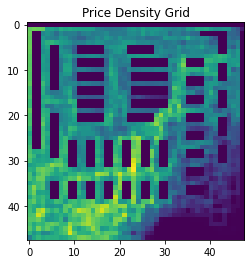

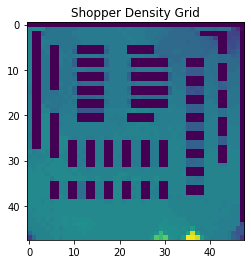

In [21]:
plt.imshow(price_density_grid)
plt.title("Price Density Grid")
plt.show()

plt.imshow(shopper_density_grid)
plt.title("Shopper Density Grid")
plt.show()

### Analysis of Crowd Density

In [22]:
total=0
for pdt in pdt_list:
    total += pdt.discounted_price*pdt.qty
    
print("No of products:", len(pdt_list))
print("Number of products in layout:", len(fig_1_layout_object.pdt_list))
print("Total Value", total)
print("Value of Goods bought",fig_1_layout_object.value_of_goods_bought )
print("Total Loss:", fig_1_layout_object.total_loss())

No of products: 1535
Number of products in layout: 0
Total Value 891784.6099999888
Value of Goods bought 891784.6099999875
Total Loss: 4274.612222222221


In [23]:
print("Standard Deviation of Shopper Density:", np.std(shopper_density_grid, axis=(0,1)))
print("Standard Deviation of Price Density:", np.std(price_density_grid, axis=(0,1)))

Standard Deviation of Shopper Density: 9.293358345162272
Standard Deviation of Price Density: 308.313190893005


### Debugging Cells

In [24]:
for pdt in fig_1_layout_object.pdt_list:
    print(pdt.index)

In [25]:
for shelf in fig_1_layout_object.shelf_list:
    print (shelf.pdt_set)

set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set(

In [26]:
for pdt in pdt_list:
    if pdt.index == 78:
        print(pdt.department)

Video Gaming
Video Gaming
Video Gaming
Video Gaming
Video Gaming
Video Gaming
Video Gaming
Video Gaming
Video Gaming
Video Gaming
